### Instruction

## Required imports

In [1]:
import nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Reads a CSV file containing email data and labels into a pandas dataframe, and then splits the data into training and testing sets

In [2]:
# Load dataset
df = pd.read_csv('../dataset/input/emails_set.csv')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['is_phishing'], test_size=0.3, random_state=42)

Download NLTK data for text tokenization and remove stop words from a dataset of email text. Apply stemming to reduce words to their base form, and add a new feature to the dataset indicating the length of each email. The processed text is represented by df['text'], while the email length feature is represented by df['email_length']

In [3]:
# Download data for tokenization
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize text into words
df['text'] = df['text'].apply(lambda x: word_tokenize(x.lower()))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

# Stem words
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda x: [stemmer.stem(word) for word in x])

# Join words back into a string
df['text'] = df['text'].apply(lambda x: " ".join(x))

# Add feature for email length
df['email_length'] = df['text'].apply(lambda x: len(x))

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Convert email text into TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

# Train a Logistic Regression
clf = LogisticRegression(random_state=42)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [5]:
# Evaluate the Random Forest classifier model on test data
random_forest_accuracy = rf.score(X_test_tfidf, y_test)
print("Accuracy of Random Forest classifier:", random_forest_accuracy)

# Evaluate the Logistic Regression model on test data
logistic_regression = clf.score(X_test_tfidf, y_test)
print("Accuracy of Logistic Regression:", logistic_regression)

Accuracy of Random Forest classifier: 0.9783333333333334
Accuracy of Logistic Regression: 0.9466666666666667


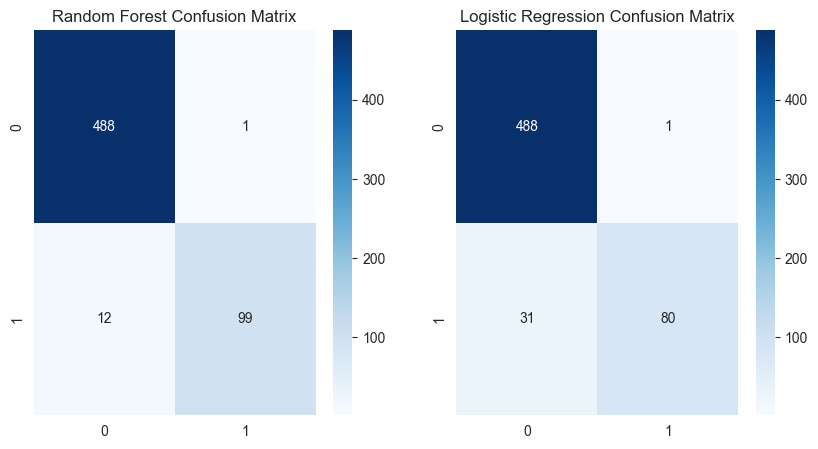

In [6]:
# Generate predictions
y_pred_rf = rf.predict(X_test_tfidf)
y_pred_lr = clf.predict(X_test_tfidf)

# Generate confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrices
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.heatmap(cm_rf, ax=ax[0], annot=True, cmap='Blues', fmt='g')
sns.heatmap(cm_lr, ax=ax[1], annot=True, cmap='Blues', fmt='g')
ax[0].set_title('Random Forest Confusion Matrix')
ax[1].set_title('Logistic Regression Confusion Matrix')
plt.show()

Random Forest Classification Report:
               precision    recall  f1-score   support

           0    0.97600   0.99796   0.98686       489
           1    0.99000   0.89189   0.93839       111

    accuracy                        0.97833       600
   macro avg    0.98300   0.94492   0.96262       600
weighted avg    0.97859   0.97833   0.97789       600

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0    0.94027   0.99796   0.96825       489
           1    0.98765   0.72072   0.83333       111

    accuracy                        0.94667       600
   macro avg    0.96396   0.85934   0.90079       600
weighted avg    0.94904   0.94667   0.94329       600



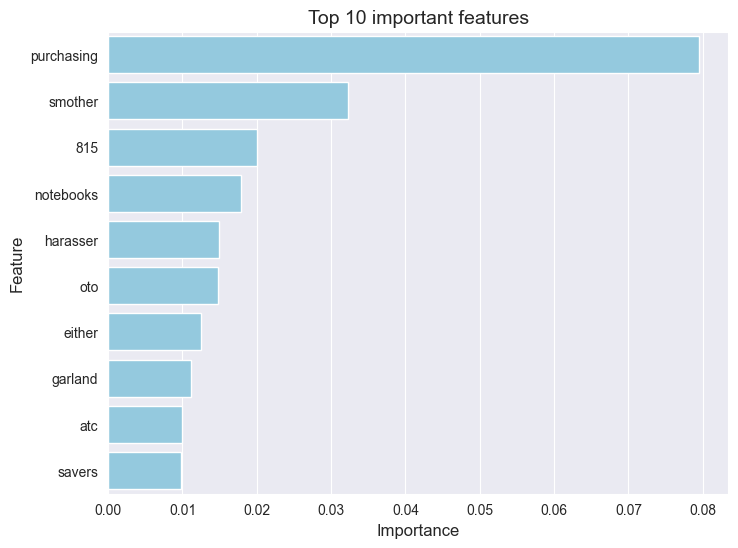

In [7]:
# Print classification reports
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred_rf, digits = 5))
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_lr, digits = 5))

# Plot feature importance
feature_importance = pd.DataFrame(list(zip(list(vectorizer.vocabulary_.keys()), rf.feature_importances_)),
                                  columns=['Feature', 'Importance'])
feature_importance = feature_importance.sort_values(by=['Importance'], ascending=False).head(10)
plt.figure(figsize=(8,6))

sns.barplot(x='Importance', y='Feature', data=feature_importance, color='skyblue')
plt.title('Top 10 important features', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

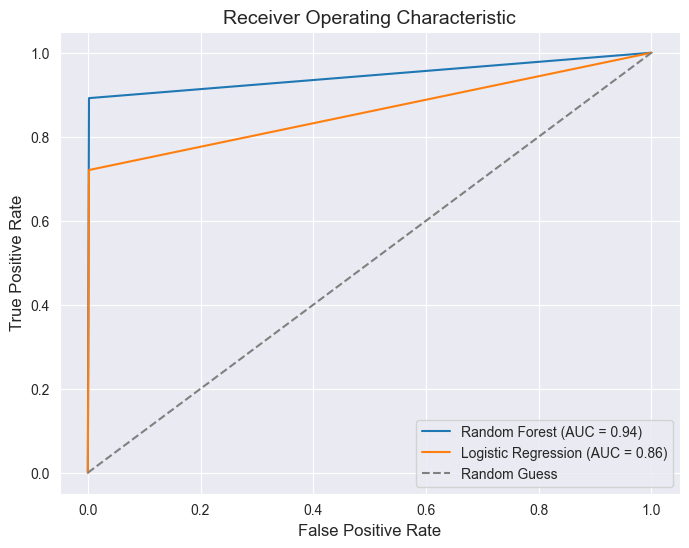

In [8]:
# Compute ROC curve and area under the curve (AUC) for Random Forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guess')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=14)
plt.legend(loc="lower right")
plt.show()